In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
train_df = pd.read_csv("E:\Kaiwalya\Github Repo\Elo-Merchant-Category-Recommendation\Data Sets\elo_train.csv", parse_dates=["first_active_month"])
test_df = pd.read_csv("E:\Kaiwalya\Github Repo\Elo-Merchant-Category-Recommendation\Data Sets\elo_test.csv", parse_dates=["first_active_month"])
print("Number of rows and columns in train set : ",train_df.shape)
print("Number of rows and columns in test set : ",test_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


In [3]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


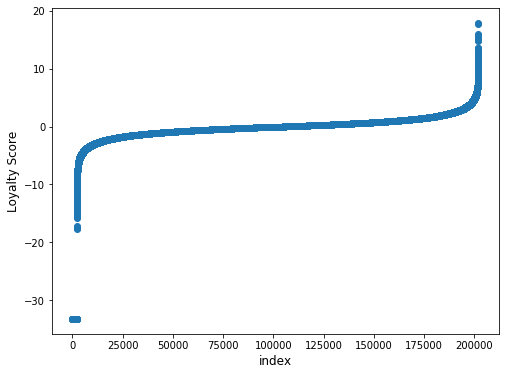

In [4]:
target_col = "target"

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

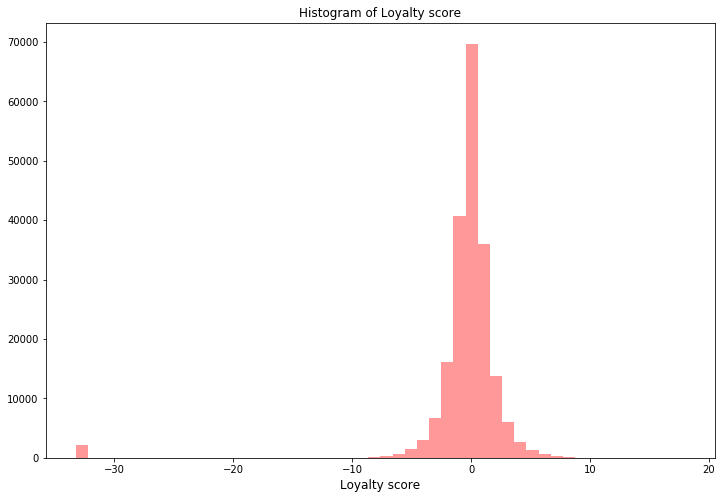

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

In [6]:
(train_df[target_col]<-30).sum()

2207

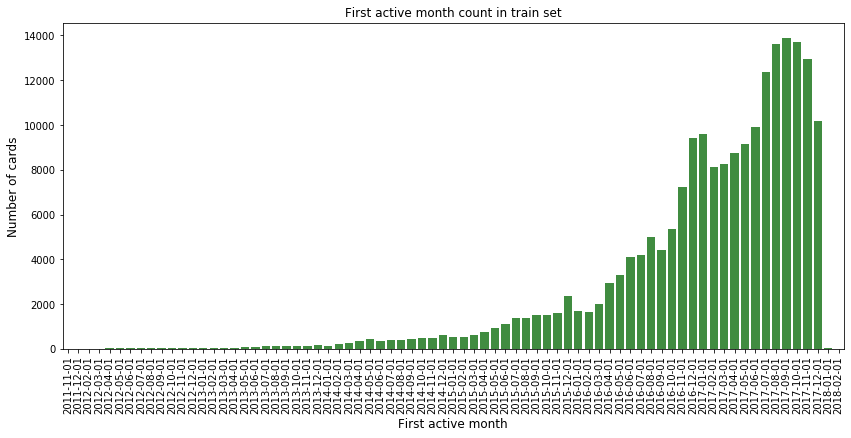

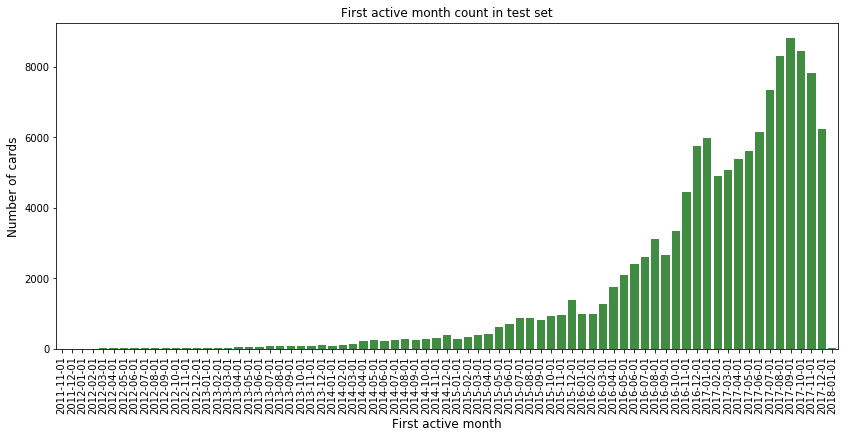

In [7]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

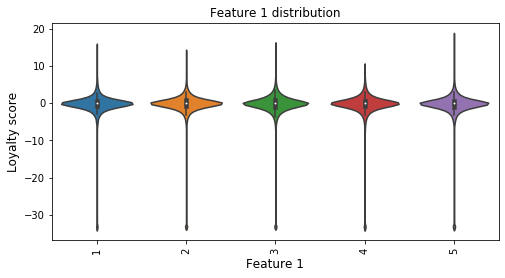

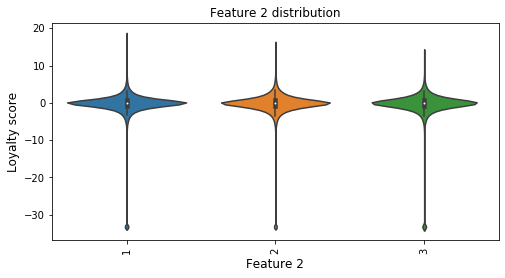

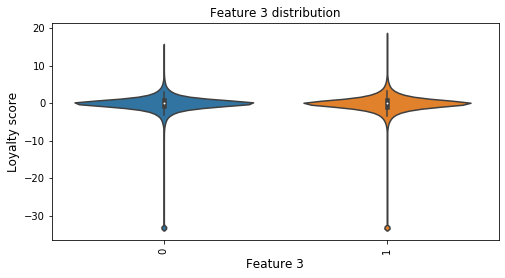

In [8]:
# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

In [9]:
hist_df = pd.read_csv("E:\Kaiwalya\Github Repo\elo_merchant_transactions.csv")
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [10]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [11]:
cnt_srs = train_df.groupby("num_hist_transactions")[target_col].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

trace = scatter_plot(cnt_srs, "orange")
layout = dict(
    title='Loyalty score by Number of historical transactions',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Histtranscnt")

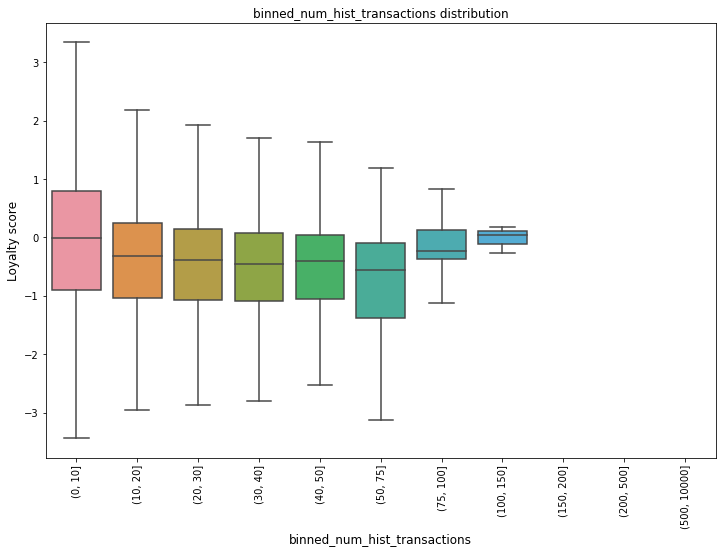

In [12]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.show()

In [13]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [14]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of historical transaction value (Binned) distribution")
plt.show()

E:\Kaiwalya\Courses\CodeQuest\ML\lib\site-packages\pandas\core\reshape\tile.py:254: RuntimeWarning:

invalid value encountered in less



ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [15]:
bins = np.percentile(train_df["mean_hist_trans"], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_mean_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned Mean Historical Transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of historical transaction value (Binned) distribution")
plt.show()

ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [16]:
new_trans_df = pd.read_csv("E:\Kaiwalya\Github Repo\Elo-Merchant-Category-Recommendation\Data Sets\elo_merchants.csv")
new_trans_df.head()

,card_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [19]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["avg_purchases_lag3"].size().reset_index()
gdf.columns = ["card_id", "num_merch_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

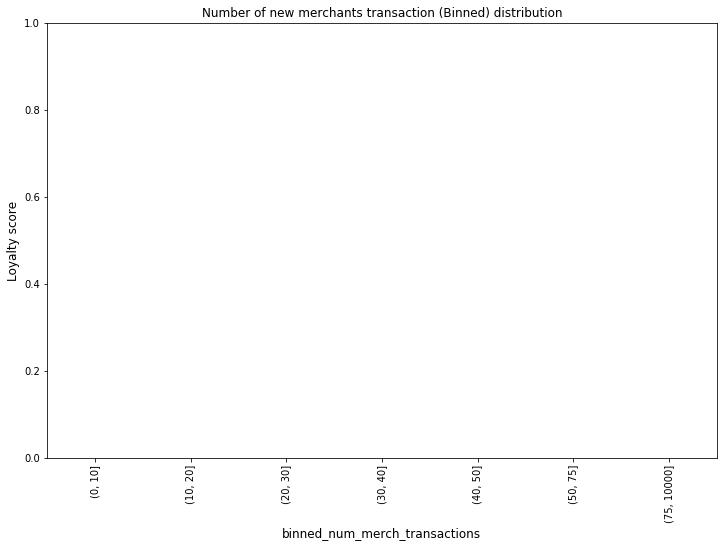

In [20]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_merch_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Number of new merchants transaction (Binned) distribution")
plt.show()

In [22]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["avg_purchases_lag3"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [23]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (Binned) distribution")
plt.show()

E:\Kaiwalya\Courses\CodeQuest\ML\lib\site-packages\numpy\lib\nanfunctions.py:1372: RuntimeWarning:

All-NaN slice encountered

E:\Kaiwalya\Courses\CodeQuest\ML\lib\site-packages\pandas\core\reshape\tile.py:254: RuntimeWarning:

invalid value encountered in less



ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [24]:
bins = np.nanpercentile(train_df["mean_merch_trans"], range(0,101,10))
train_df['binned_mean_merch_trans'] = pd.cut(train_df['mean_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of New merchants transaction value (Binned) distribution")
plt.show()

ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [25]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month", 
               "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", 
               "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans",
              ]

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.
    

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.82215
Early stopping, best iteration is:
[60]	valid_0's rmse: 3.82178
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.76834
[200]	valid_0's rmse: 3.76934
Early stopping, best iteration is:
[116]	valid_0's rmse: 3.76802
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.8097
[200]	valid_0's rmse: 3.81071
Early stopping, best iteration is:
[124]	valid_0's rmse: 3.80949
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.80208
Early stopping, best iteration is:
[84]	valid_0's rmse: 3.80179
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.86188
[200]	valid_0's rmse: 3.86278
Early stopping, best iteration is:
[102]	valid_0's rmse: 3.86172


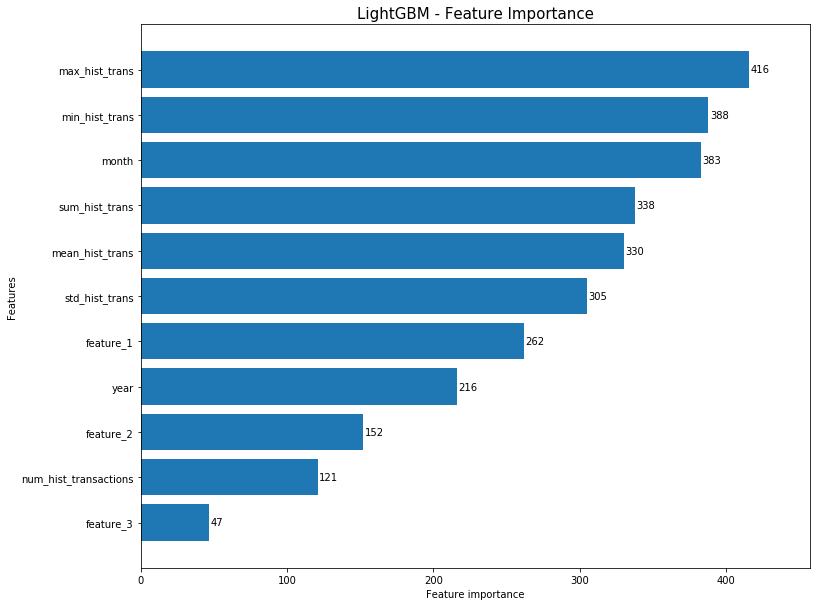

In [26]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [27]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)